In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.unit_transformations import unit_direction_transformation
from project_ssms.feature_funcs import f_corner_vec_func, feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import k_step_prediction_for_grid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces
from project_ssms.grid_utils import *

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

import joblib

# data

In [3]:
trajs_all = joblib.load("trajs_all")
trajs = trajs_all[36000*0:36000*1]
f_trajs = filter_traj_by_speed(trajs, q1=0.9, q2=0.9)

In [8]:
ARENA_XMIN = 5
ARENA_XMAX = 325
ARENA_YMIN = -10
ARENA_YMAX = 390

In [9]:
# make 3 by 3 grid world
x_grid_gap = (ARENA_XMAX - ARENA_XMIN) / 3
y_grid_gap = (ARENA_YMAX - ARENA_YMIN) / 3

x_grids = [ARENA_XMIN + i * x_grid_gap for i in range(4)]
y_grids = [ARENA_YMIN + i * y_grid_gap for i in range(4)]

In [12]:
bounds = np.array([[ARENA_XMIN, ARENA_XMAX], [ARENA_YMIN, ARENA_YMAX], 
                   [ARENA_XMIN, ARENA_XMAX], [ARENA_YMIN, ARENA_YMAX]])

In [13]:
bounds

array([[  5, 325],
       [-10, 390],
       [  5, 325],
       [-10, 390]])

In [14]:
# feature_funcs
CORNERS = torch.tensor([[ARENA_XMIN, ARENA_YMIN], [ARENA_XMIN, ARENA_YMAX],
                        [ARENA_XMAX, ARENA_YMIN], [ARENA_XMAX, ARENA_YMAX]], dtype=torch.float64)

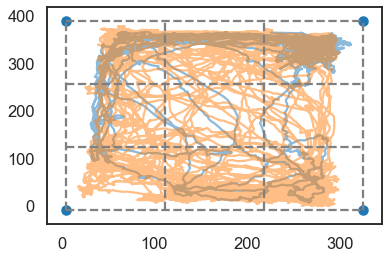

In [15]:
plot_2_mice(trajs, alpha=0.5)
add_grid(x_grids, y_grids)

In [16]:
trajs.shape

(36000, 4)

<Figure size 864x360 with 0 Axes>

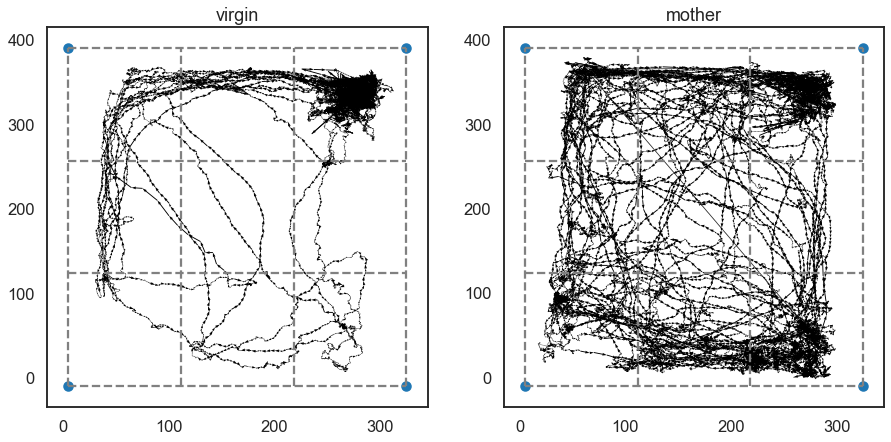

In [17]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(trajs, x_grids, y_grids, scale=1)

In [88]:
n_x = len(x_grids) - 1
n_y = len(y_grids) - 1
G = n_x * n_y

In [362]:
def get_angles_single(data):
    # data: np.ndarray
    start = data[:-1]
    end = data[1:]
    dXY = end - start # (T-1, 2)
    #o = np.sqrt(dXY[:,1]**2 + dXY[:,0]**2)  # (T-1, 2)
    angles = np.arctan(dXY[:, 1]/(dXY[:,0]+1e-8))  # (T-1, )
    
    angles_qs_add = [0, np.pi, np.pi, 2*np.pi]
    
    qs = find_Q_masks(dXY)
    for i in range(4):
        angles[qs[i]] = angles[qs[i]] + angles_qs_add[i]
    return angles

def get_angles_single_from_quiver(dXY):
    angles = np.arctan(dXY[:, 1]/(dXY[:,0]+1e-8))  # (T-1, )
    
    angles_qs_add = [0, np.pi, np.pi, 2*np.pi]
    
    qs = find_Q_masks(dXY)
    for i in range(4):
        angles[qs[i]] = angles[qs[i]] + angles_qs_add[i]
    return angles

In [261]:
def find_Q_masks(data):
    # no considering origin
    q1 = ((data[:,0] > 0) & (data[:,1] >= 0))
    q2 = (data[:,0] <= 0) & (data[:,1] > 0)
    q3 = (data[:,0] < 0) & (data[:, 1] <= 0)
    q4 = (data[:,0] >=0) & (data[:, 1]< 0)
    qs = np.stack((q1, q2, q3, q4), axis=0)
    #print(qs)
    assert np.all(qs.sum(axis=0) == 1)
    return qs

In [262]:
# test
test_data = np.array([[0.0, 0.0], [1, 1], [0, 0], [1,-1], [1-1, -1+np.sqrt(3)]])
out = get_angles_single(test_data)

In [265]:
out / np.pi

array([0.25      , 1.25      , 1.75      , 0.66666667])

In [394]:
def get_all_angles(data):
    if isinstance(data, np.ndarray):
        data = torch.tensor(data, dtype=torch.float64)
    masks_a, masks_b = tran.get_masks(data)
    
    angles_a = []
    angles_b = []
    for g in range(G):
        data_a_g = data[masks_a[g] == 1][:,0:2].numpy()
        data_b_g = data[masks_b[g] == 1][:,2:4].numpy()
        
        angles_a.append(get_angles_single(data_a_g))
        angles_b.append(get_angles_single(data_b_g))
        
    return angles_a, angles_b


def get_all_angles_from_quiver(XY, dXY):
    # XY and dXY should have the same shape
    if isinstance(XY, np.ndarray):
        XY = torch.tensor(XY, dtype=torch.float64)
    masks_a, masks_b = tran.get_masks(XY)
    masks_a = masks_a.numpy()
    masks_b = masks_b.numpy()
    
    angles_a = []
    angles_b = []
    for g in range(G):
        dXY_a_g = dXY[masks_a[g] == 1][:, 0:2]
        dXY_b_g = dXY[masks_b[g] == 1][:, 2:4]
        
        angles_a.append(get_angles_single_from_quiver(dXY_a_g))
        angles_b.append(get_angles_single_from_quiver(dXY_b_g))
    
    return angles_a, angles_b

In [309]:
# test

#test_data = np.array([[10, 10, 10, 10], [12, 12, 8, 8]])
test_data = np.array([[150+10, 150+10, 10, 10], [150+12, 150+12, 8, 8]])

out1, out2 = get_all_angles(test_data)

In [310]:
out1

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([0.78539816]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64)]

In [311]:
data_angles_a, data_angles_b = get_all_angles(data[:35998])

In [312]:
data_angles_a[0].shape

(355,)

In [422]:
def plot_angles(angles, title_name, bins=50, hist=True):
    plt.figure(figsize=(16,12))
    plt.suptitle(title_name, fontsize=20)

    for i in range(n_x):
        for j in range(n_y):
            plot_idx = (n_y - j - 1) * n_x + i + 1
            plt.subplot(n_y, n_x, plot_idx)

            grid_idx = i * n_y + j
            if hist:
                plt.hist(angles[grid_idx], bins=bins);
            else:
                sns.kdeplot(angles[grid_idx])
            plt.xlim(0, 2*np.pi)
            plt.xlim(0, 2*np.pi)
            plt.xticks([0, np.pi/2, np.pi, np.pi/2*3, 2*np.pi], [0, r'$\pi/2$', r'$\pi$',r'$3\pi/2$',r'$2\pi$']);

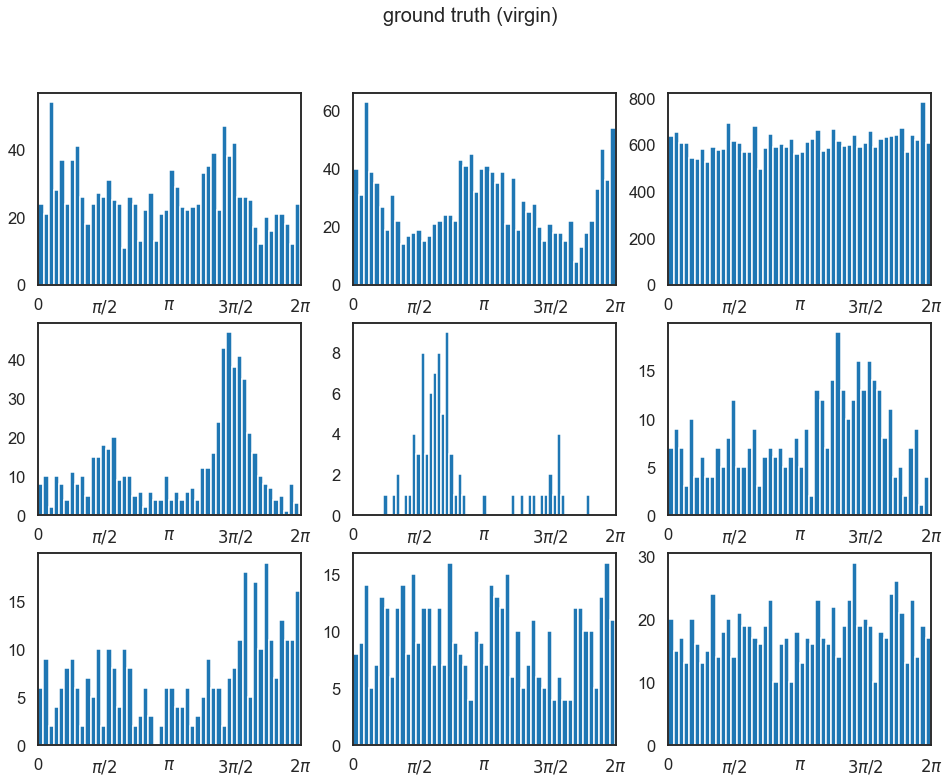

In [424]:
plot_angles(data_angles_a, "ground truth (virgin)", 50, True)

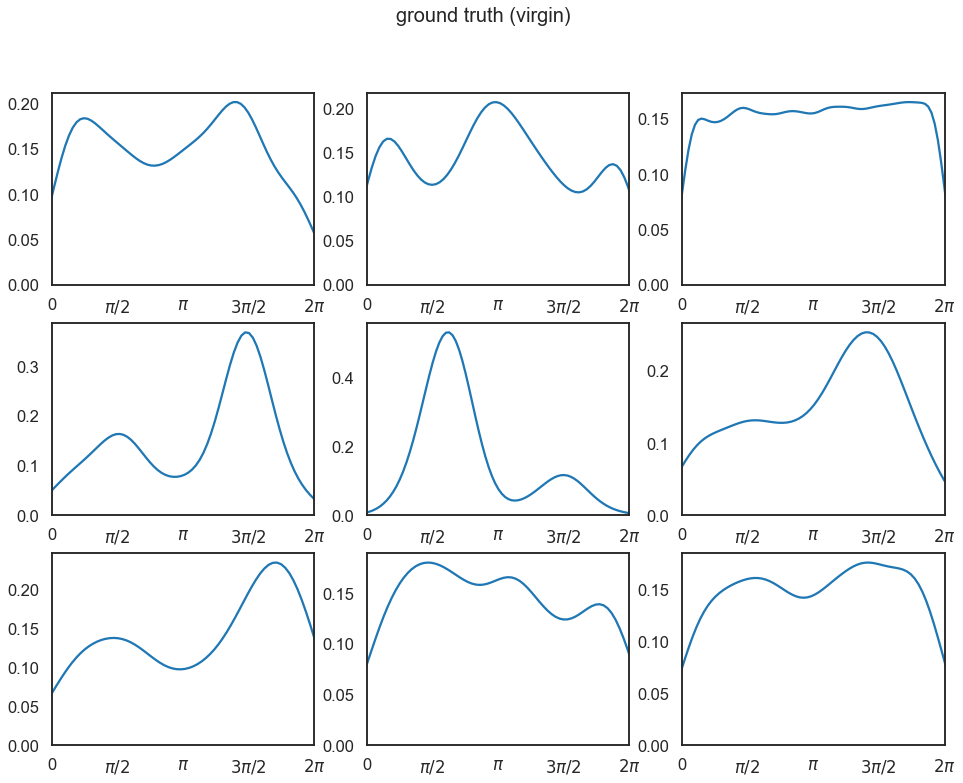

In [423]:
plot_angles(data_angles_a, "ground truth (virgin)", 50, False)

In [319]:
sample_x_angles_a, sample_x_angles_b = get_all_angles(sample_x)

In [475]:
sample_x_center_angles_a, sample_x_center_angles_b = get_all_angles(sample_x_center)

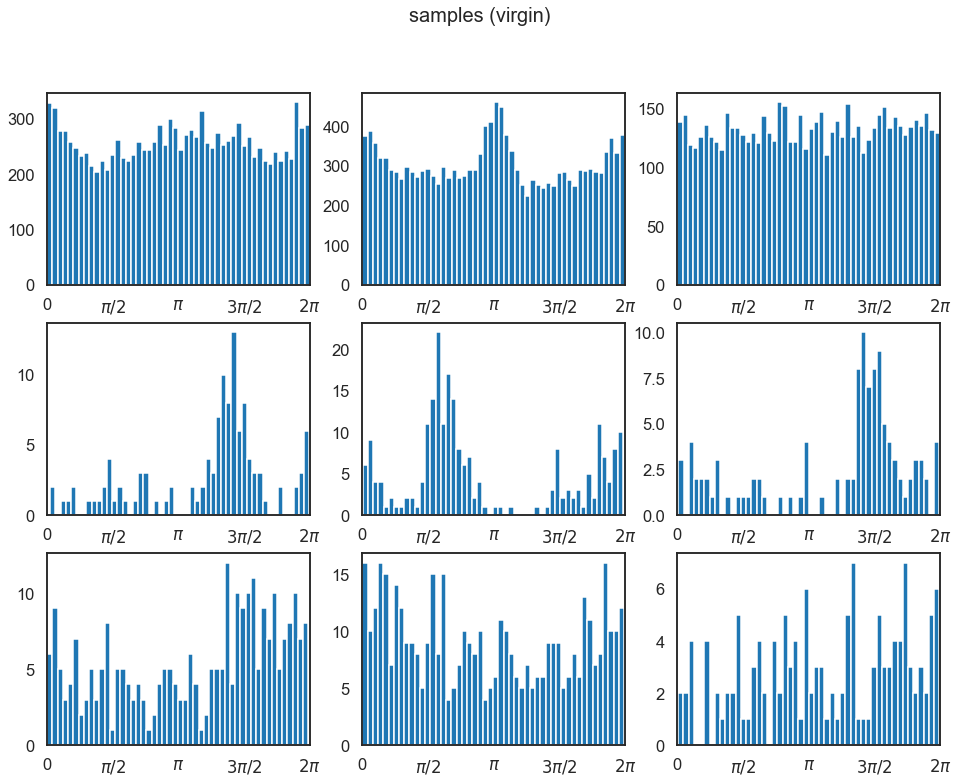

In [374]:
plot_angles(sample_x_angles_a, "samples (virgin)", 50)

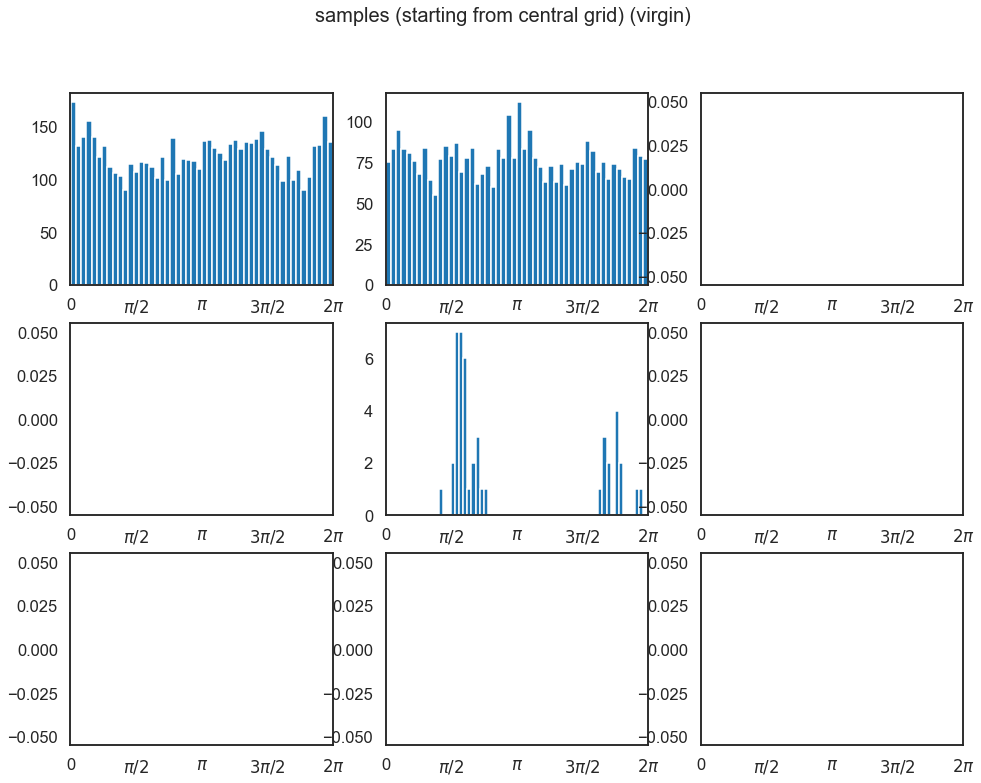

In [419]:
plot_angles(sample_x_center_angles_a, "samples (starting from central grid) (virgin)", 50)

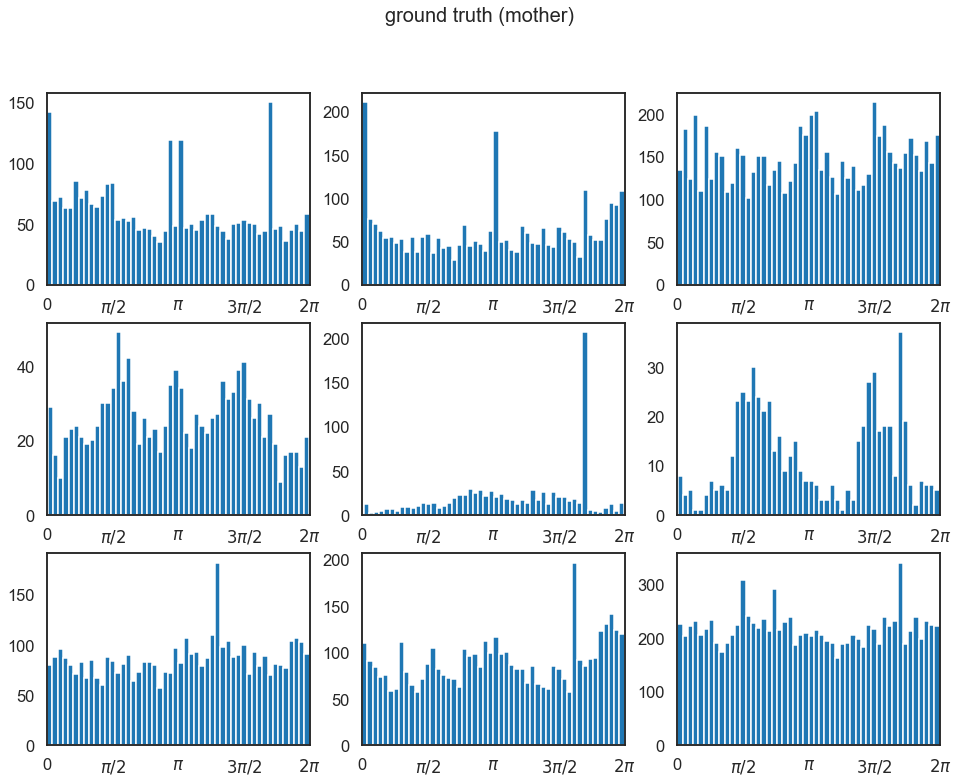

In [415]:
plot_angles(data_angles_b, "ground truth (mother)", 50)

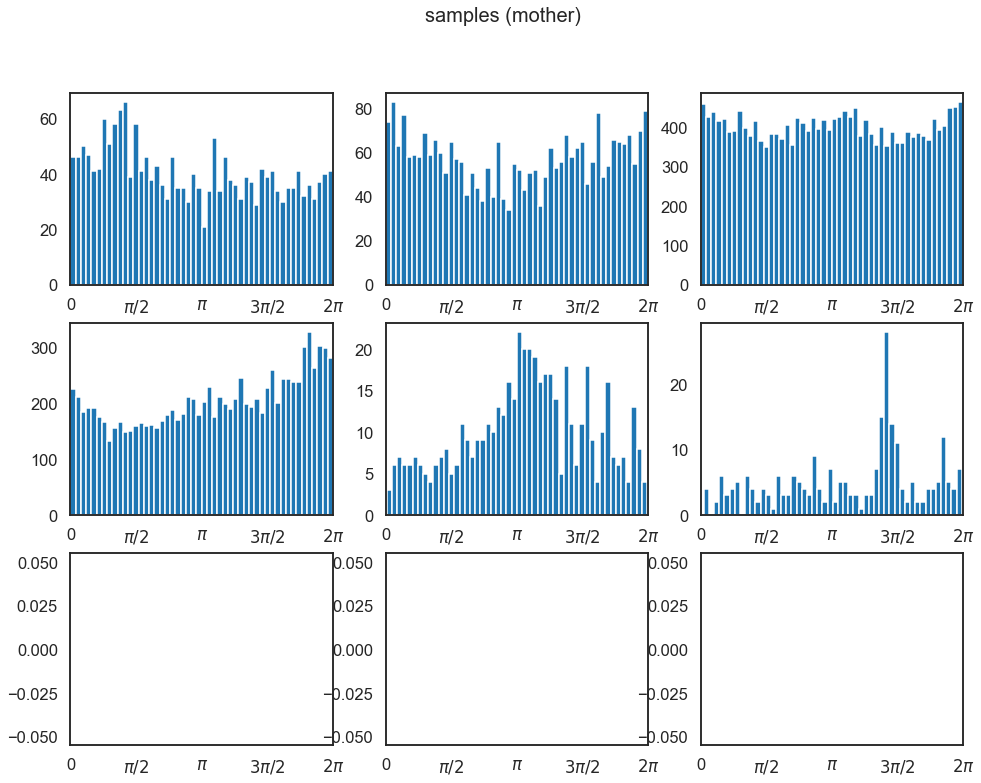

In [416]:
plot_angles(sample_x_angles_b, "samples (mother)", 50)

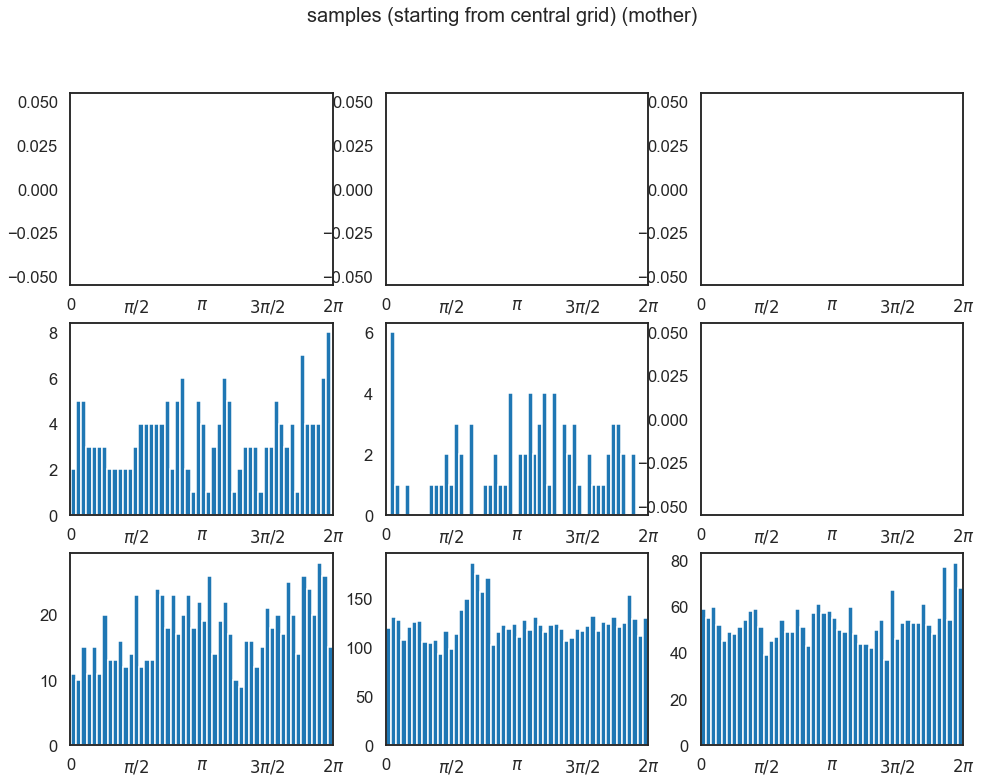

In [418]:
plot_angles(sample_x_center_angles_b, "samples (starting from central grid) (mother)", 50)

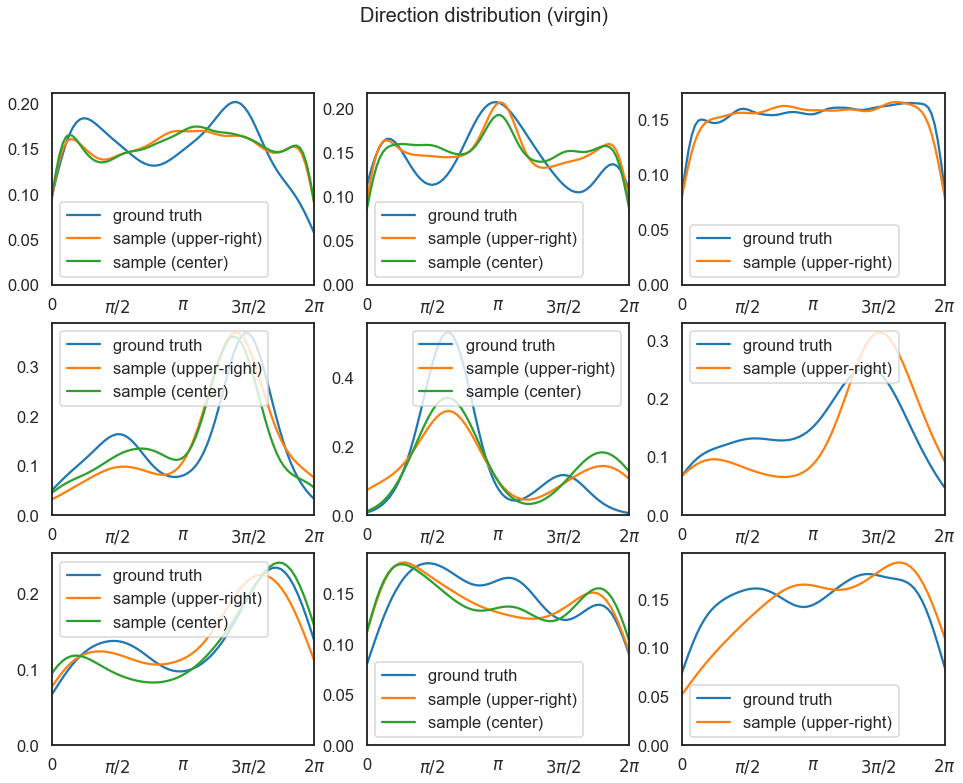

In [476]:
plt.figure(figsize=(16,12))
plt.suptitle("Direction distribution (virgin)", fontsize=20)

for i in range(n_x):
    for j in range(n_y):
        plot_idx = (n_y - j - 1) * n_x + i + 1
        plt.subplot(n_y, n_x, plot_idx)

        grid_idx = i * n_y + j
        
        sns.kdeplot(data_angles_a[grid_idx], label='ground truth')
        sns.kdeplot(sample_x_angles_a[grid_idx], label='sample (upper-right)')
        sns.kdeplot(sample_x_center_angles_a[grid_idx], label='sample (center)')
        plt.legend()
        plt.xlim(0, 2*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.xticks([0, np.pi/2, np.pi, np.pi/2*3, 2*np.pi], [0, r'$\pi/2$', r'$\pi$',r'$3\pi/2$',r'$2\pi$']);
    
plt.savefig("direction_v.jpg")

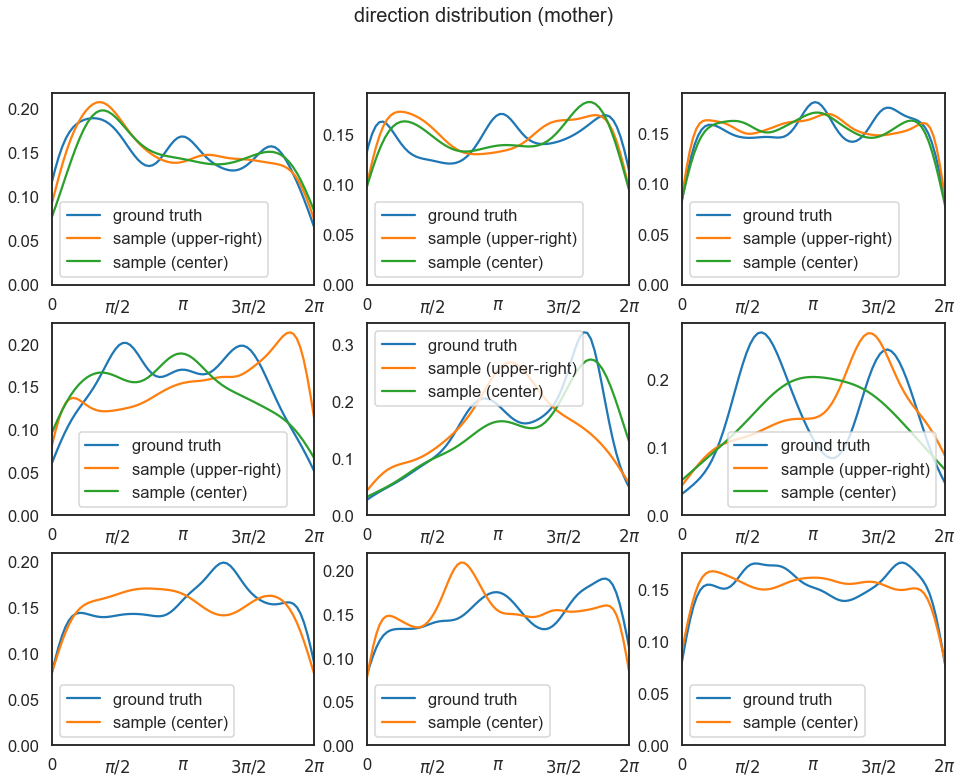

In [477]:
plt.figure(figsize=(16,12))
plt.suptitle("direction distribution (mother)", fontsize=20)

for i in range(n_x):
    for j in range(n_y):
        plot_idx = (n_y - j - 1) * n_x + i + 1
        plt.subplot(n_y, n_x, plot_idx)

        grid_idx = i * n_y + j
        
        sns.kdeplot(data_angles_b[grid_idx], label='ground truth')
        sns.kdeplot(sample_x_angles_b[grid_idx], label='sample (upper-right)')
        sns.kdeplot(sample_x_center_angles_b[grid_idx], label='sample (center)')
        plt.legend()
        plt.xlim(0, 2*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.xticks([0, np.pi/2, np.pi, np.pi/2*3, 2*np.pi], [0, r'$\pi/2$', r'$\pi$',r'$3\pi/2$',r'$2\pi$']);
        
plt.savefig("direction_m.jpg")

In [452]:
def get_speed(data):
    # data (T, 4)
    if isinstance(data, np.ndarray):
        diff = np.diff(data, axis=0) # (T-1, 4)
        data = torch.tensor(data, dtype=torch.float64)
        masks_a, masks_b = tran.get_masks(data[:-1])
    elif isinstance(data, torch.Tensor):
        masks_a, masks_b = tran.get_masks(data[:-1])
        diff = np.diff(data.numpy(), axis=0) # (T-1, 4)
    else:
        raise ValueError("Data must be either np.ndarray or torch.Tensor")
    
    speed_a_all = np.sqrt(diff[:,0]**2 + diff[:,1]**2) # (T-1, 2)
    speed_b_all = np.sqrt(diff[:,2]**2 + diff[:,3]**2) # (T-1, 2)
    
    speed_a = []
    speed_b = []
    for g in range(G):
        speed_a_g = speed_a_all[masks_a[g].numpy() == 1]
        speed_b_g = speed_b_all[masks_b[g].numpy() == 1]
        
        speed_a.append(speed_a_g)
        speed_b.append(speed_b_g)
    
    return speed_a, speed_b
    

In [478]:
data_speed_a, data_speed_b = get_speed(data)
sample_x_speed_a, sample_x_speed_b = get_speed(sample_x)
sample_x_center_speed_a, sample_x_center_speed_b = get_speed(sample_x_center)

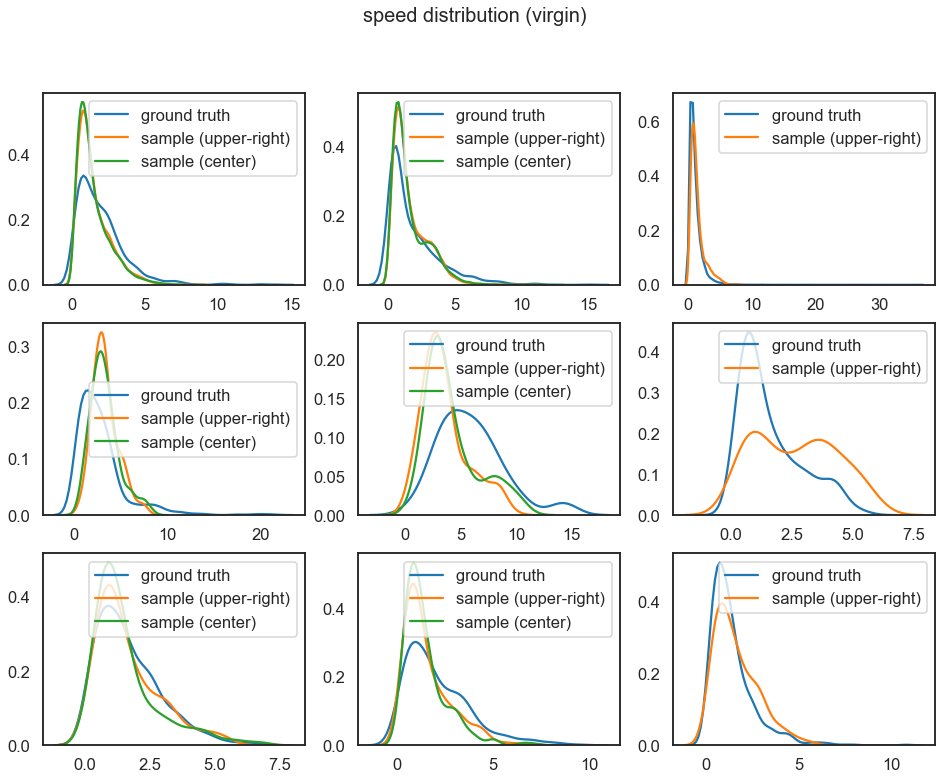

In [479]:
plt.figure(figsize=(16,12))
plt.suptitle("speed distribution (virgin)", fontsize=20)

for i in range(n_x):
    for j in range(n_y):
        plot_idx = (n_y - j - 1) * n_x + i + 1
        plt.subplot(n_y, n_x, plot_idx)

        grid_idx = i * n_y + j
        
        sns.kdeplot(data_speed_a[grid_idx], label='ground truth')
        sns.kdeplot(sample_x_speed_a[grid_idx], label='sample (upper-right)')
        sns.kdeplot(sample_x_center_speed_a[grid_idx], label='sample (center)')
        plt.legend()

plt.savefig("speed_v.jpg")

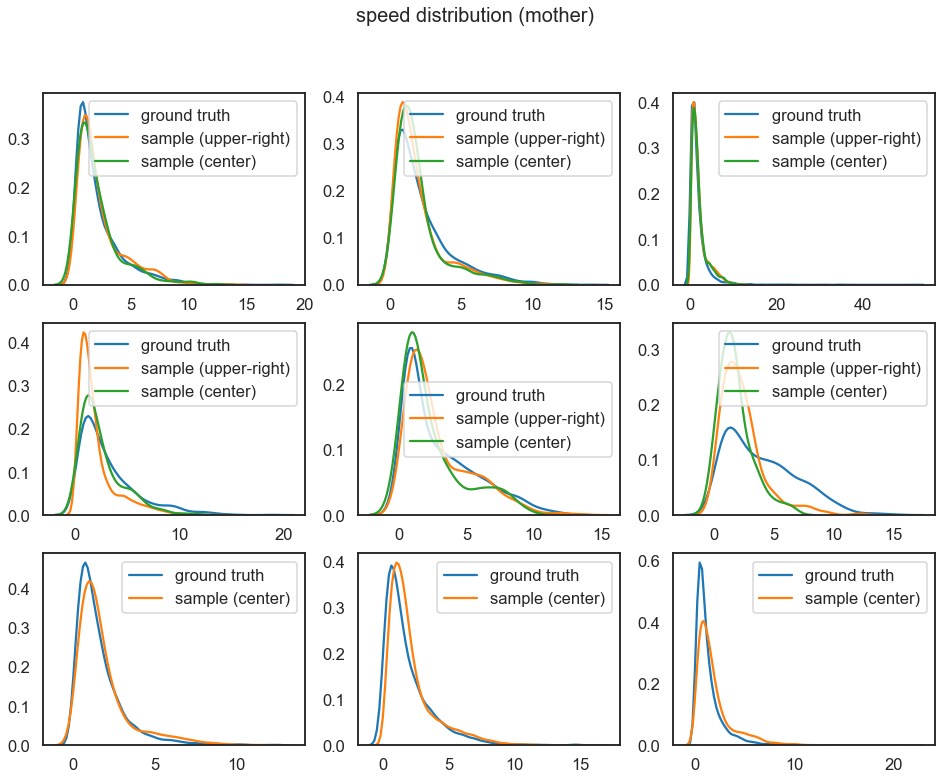

In [480]:
plt.figure(figsize=(16,12))
plt.suptitle("speed distribution (mother)", fontsize=20)

for i in range(n_x):
    for j in range(n_y):
        plot_idx = (n_y - j - 1) * n_x + i + 1
        plt.subplot(n_y, n_x, plot_idx)

        grid_idx = i * n_y + j
        
        sns.kdeplot(data_speed_b[grid_idx], label='ground truth')
        sns.kdeplot(sample_x_speed_b[grid_idx], label='sample (upper-right)')
        sns.kdeplot(sample_x_center_speed_b[grid_idx], label='sample (center)')
        plt.legend()

plt.savefig("speed_m.jpg")

In [403]:
tran_k0_angles_a, tran_k0_angles_b = get_all_angles_from_quiver(XY_grids, dXY[:,0])
tran_k1_angles_a, tran_k1_angles_b = get_all_angles_from_quiver(XY_grids, dXY[:,1])
tran_k2_angles_a, tran_k2_angles_b = get_all_angles_from_quiver(XY_grids, dXY[:,2])
tran_k3_angles_a, tran_k3_angles_b = get_all_angles_from_quiver(XY_grids, dXY[:,3])

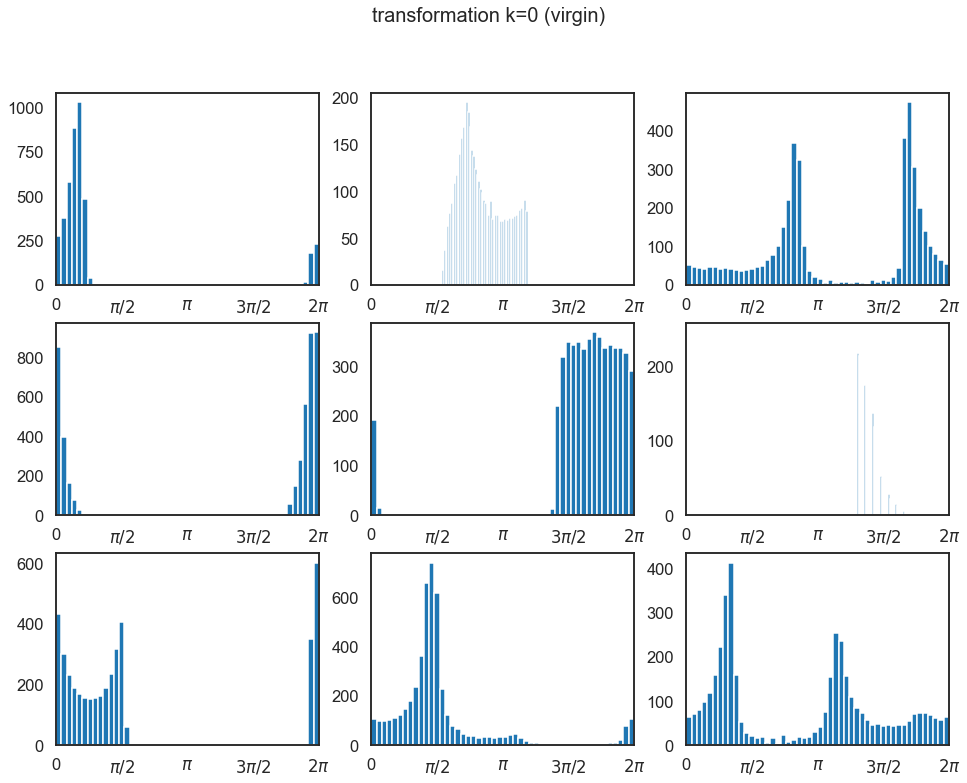

In [402]:
plot_angles(tran_k0_angles_a, "transformation k=0 (virgin)", 50)

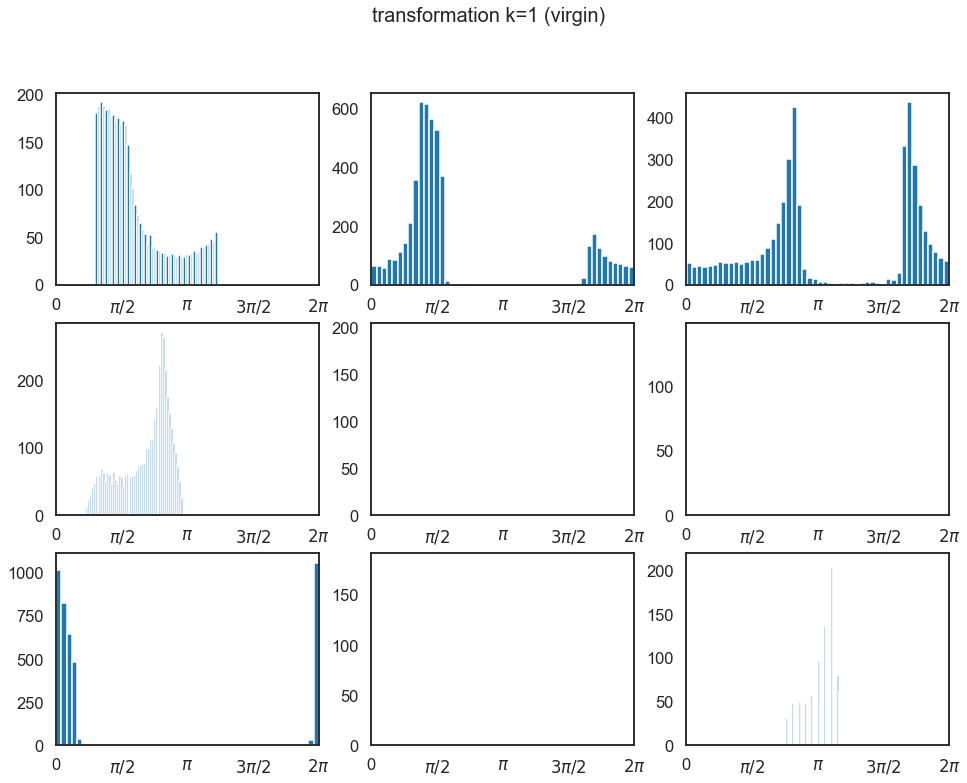

In [404]:
plot_angles(tran_k1_angles_a, "transformation k=1 (virgin)", 50)

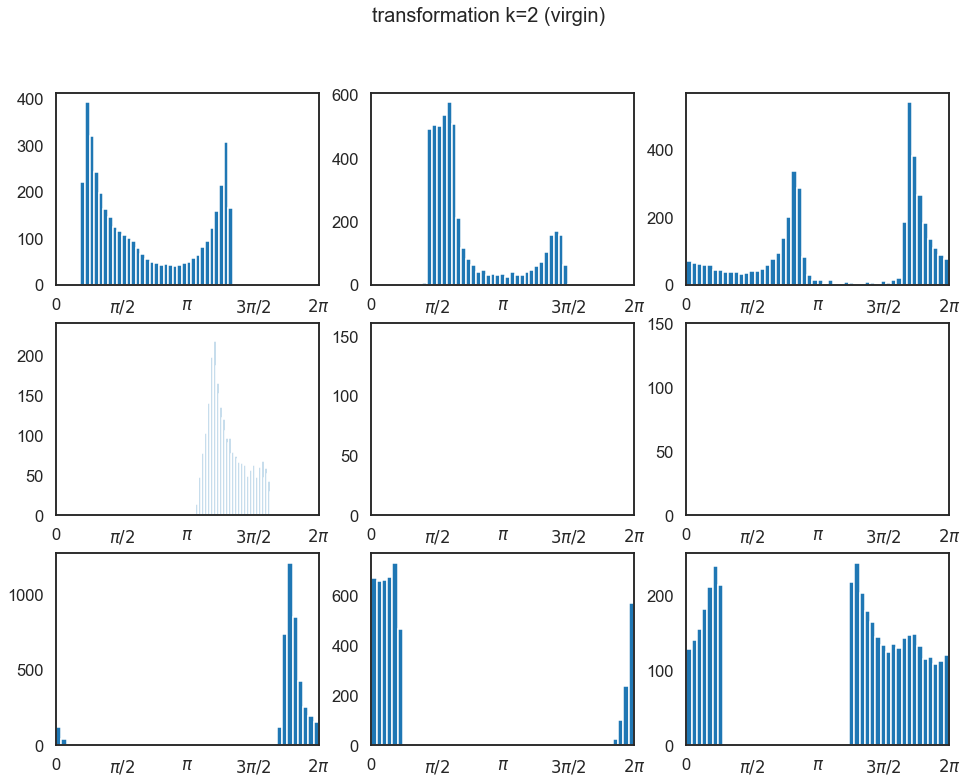

In [405]:
plot_angles(tran_k2_angles_a, "transformation k=2 (virgin)", 50)

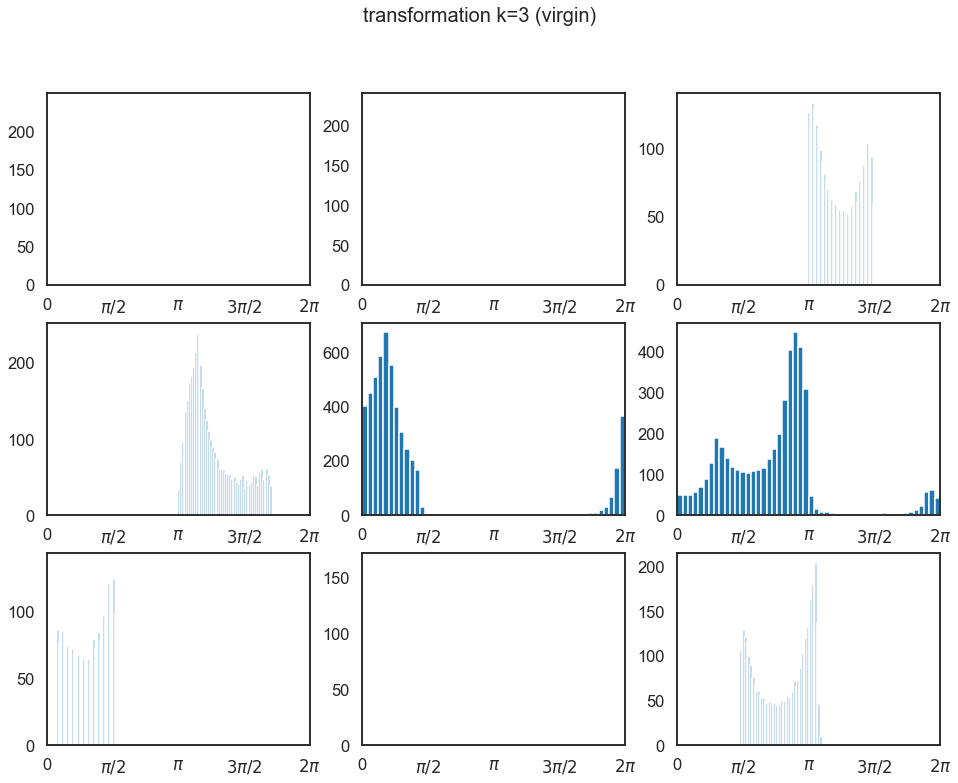

In [406]:
plot_angles(tran_k3_angles_a, "transformation k=3 (virgin)", 50)

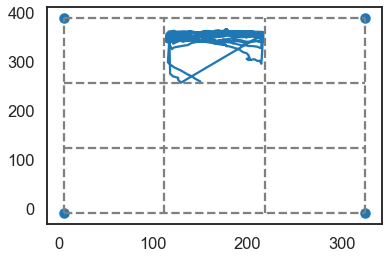

In [115]:
out = data[:-1][masks_a[5] == 1]
plt.plot(out[:,0].numpy(), out[:,1].numpy())
add_grid(x_grids, y_grids)

In [95]:
x_grids

[5.0, 111.66666666666667, 218.33333333333334, 325.0]

In [96]:
y_grids

[-10.0, 123.33333333333334, 256.6666666666667, 390.0]

In [18]:
data = torch.tensor(trajs, dtype=torch.float64)

In [19]:
diff = np.diff(trajs, axis=0)

In [20]:
np.max(np.abs(diff), axis=0)

array([26.74338913, 26.91288567, 43.59845507, 30.09817195])

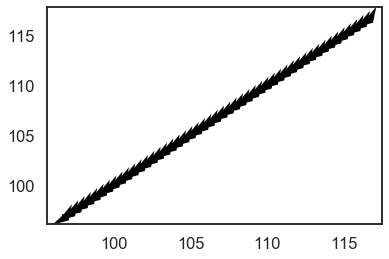

In [30]:
start = trajs[1500:1550-1, 2:4]
end = trajs[1500+1:1550, 2:4]
dxy = end - start

plt.quiver(start[:,0], end[:,0], dxy[:,0], dxy[:,1], angles='xy', scale_units='xy', scale=1, headwidth=16)

# model

In [13]:
torch.manual_seed(0)
np.random.seed(0)

D = 4
K = 4
M = 0

Df = 4

bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])


tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, unit_transformation="direction",
                          Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=10)

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

# model
model = HMM(K=K, D=D, M=M, observation=obs)


In [14]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [15]:
log_prob = model.log_likelihood(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

In [16]:
log_prob

tensor(-1971781.6506, dtype=torch.float64, grad_fn=<AddBackward0>)

In [20]:
def f_corner_vec_func_p(s):
    return feature_direction_vec(s, CORNERS)

In [25]:
model_r = joblib.load("model_k4")

In [26]:
model_r

In [30]:
model_r.log_likelihood(data)

tensor(-227688.1493, dtype=torch.float64, grad_fn=<AddBackward0>)

In [31]:
model.params = model_r.params

In [32]:
model.log_likelihood(data)

tensor(-227773.6983, dtype=torch.float64, grad_fn=<AddBackward0>)

In [15]:
##################### training ############################

num_iters = 2000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 263375.87: 100%|██████████| 2000/2000 [24:06<00:00,  1.61it/s]


In [19]:
##################### training ############################

num_iters = 2000
losses, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 232752.12: 100%|██████████| 2000/2000 [28:18<00:00,  1.57it/s]


In [21]:
##################### training ############################

num_iters = 2000
losses_2, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 228575.31: 100%|██████████| 2000/2000 [20:34<00:00,  1.30it/s]


In [79]:
##################### training ############################

num_iters = 2000
losses_3, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 227698.30: 100%|██████████| 2000/2000 [28:47<00:00,  1.22it/s]


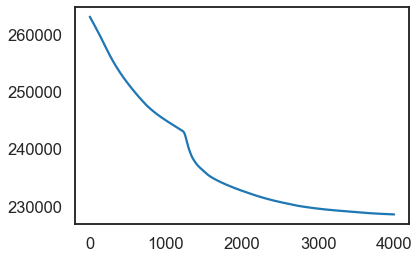

In [22]:
plt.plot(losses + losses_2)

In [31]:
model = joblib.load("model_k4_correct")

In [32]:
tran = model.observation.transformation
K = model.K
D = model.D
M = model.M
Df = 4

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

In [33]:
print("inferiring most likely states...")
z = model.most_likely_states(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

inferiring most likely states...


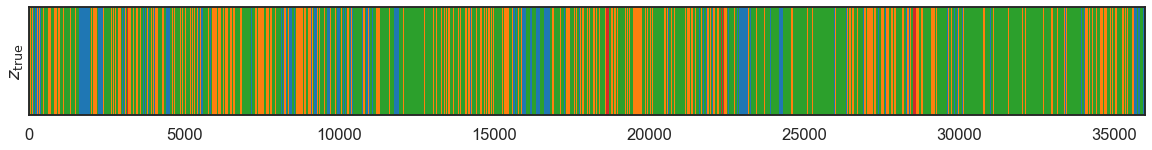

In [35]:
plot_z(z, K)

In [36]:
print("0 step prediction")
x_predict = k_step_prediction_for_grid_model(model, z, data, memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

0 step prediction


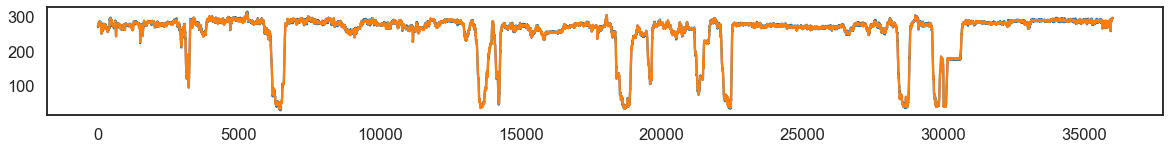

In [37]:
plt.figure(figsize=(20,2))
plt.plot(x_predict[:,0])
plt.plot(data[:,0].numpy())

In [38]:
np.mean(np.abs(x_predict-data.numpy()), axis=0)

array([1.17824433, 1.16844356, 1.77453878, 1.73515389])

# sample

In [39]:
sample_z, sample_x = model.sample(36000)

In [40]:
sample_z_2, sample_x_2 = model.sample(36000)

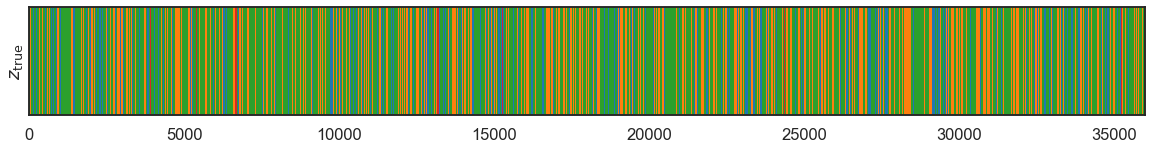

In [42]:
plot_z(sample_z, K)

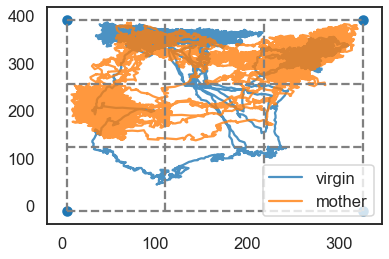

In [43]:
plot_2_mice(sample_x)
plt.legend()
add_grid(x_grids, y_grids)

In [44]:
[sum(sample_z ==k) for k in range(K)]

[4796, 10058, 20859, 287]

In [45]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7438, 0.7755, 0.4080, 0.3120],
        [1.9807, 2.0146, 3.2856, 3.3133],
        [0.7220, 0.6986, 1.0906, 1.0200],
        [1.0762, 1.2390, 1.9742, 1.7643]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

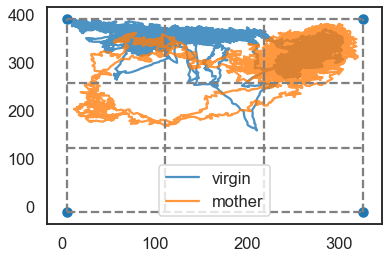

In [46]:
plot_2_mice(sample_x_2)
plt.legend()
add_grid(x_grids, y_grids)

In [42]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7438, 0.7755, 0.4080, 0.3120],
        [1.9807, 2.0146, 3.2856, 3.3133],
        [0.7220, 0.6986, 1.0906, 1.0200],
        [1.0762, 1.2390, 1.9742, 1.7643]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

<Figure size 720x360 with 0 Axes>

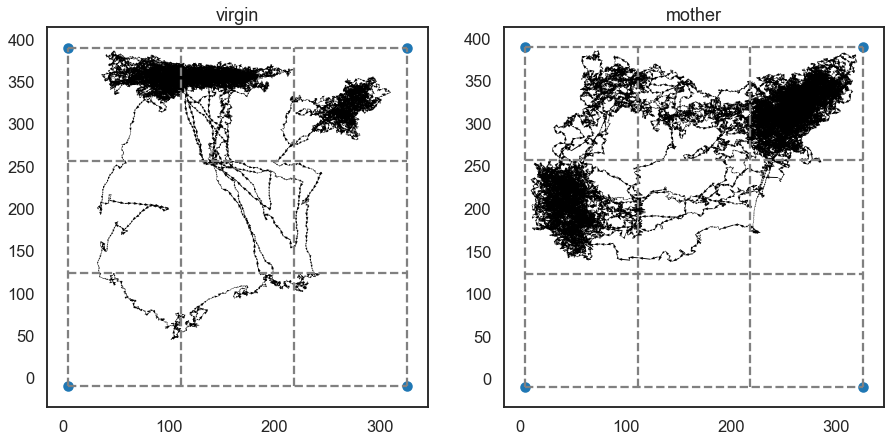

In [47]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x, x_grids, y_grids, scale=1)

<Figure size 720x360 with 0 Axes>

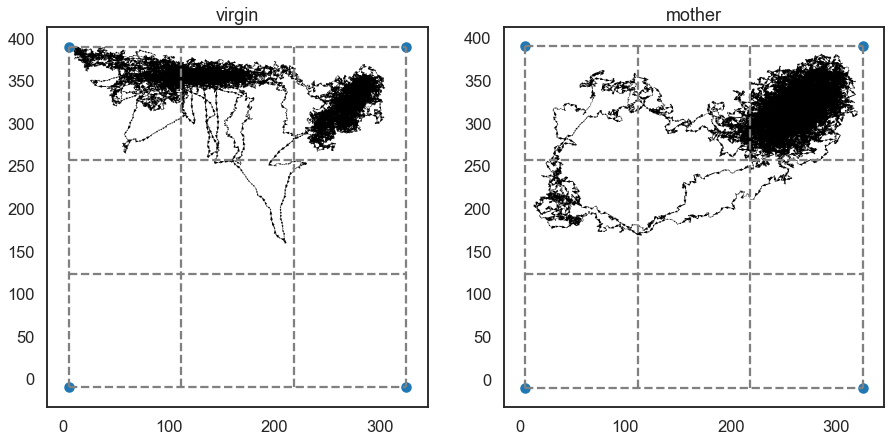

In [48]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_2, x_grids, y_grids, scale=1)

<Figure size 720x360 with 0 Axes>

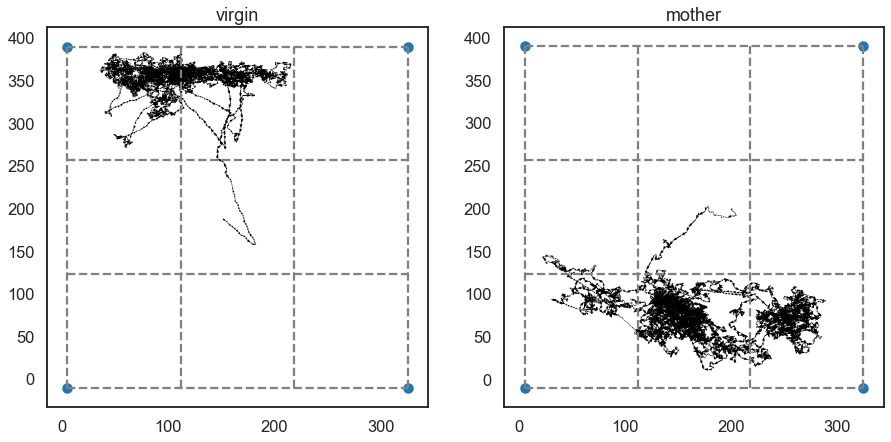

In [466]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center, x_grids, y_grids, scale=1)

In [407]:
center_z = torch.tensor([0], dtype=torch.int)
center_x = torch.tensor([[150, 190, 200, 200]], dtype=torch.float64)

In [471]:
sample_z_center, sample_x_center = model.sample(36000, prefix=(center_z, center_x))

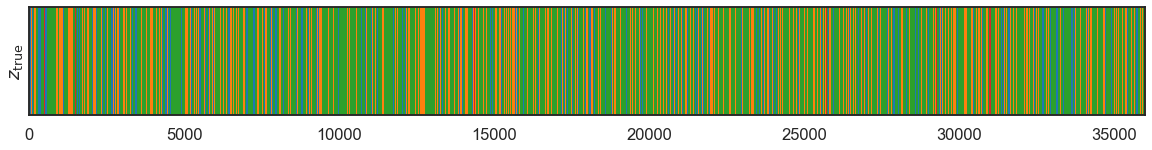

In [472]:
plot_z(sample_z_center, K)

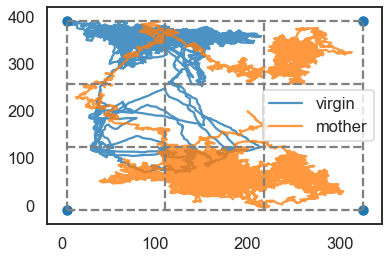

In [473]:
plot_2_mice(sample_x_center)
plt.legend()
add_grid(x_grids, y_grids)

<Figure size 720x360 with 0 Axes>

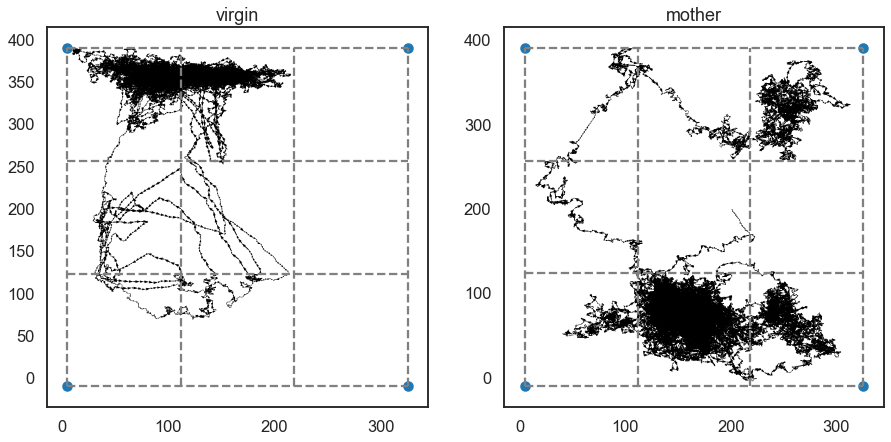

In [474]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center, x_grids, y_grids, scale=1)

In [465]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7438, 0.7755, 0.4080, 0.3120],
        [1.9807, 2.0146, 3.2856, 3.3133],
        [0.7220, 0.6986, 1.0906, 1.0200],
        [1.0762, 1.2390, 1.9742, 1.7643]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [467]:
sample_z_center2, sample_x_center2 = model.sample(36000, prefix=(center_z, center_x))

In [469]:
sample_z_center3, sample_x_center3 = model.sample(36000, prefix=(center_z, center_x))

<Figure size 720x360 with 0 Axes>

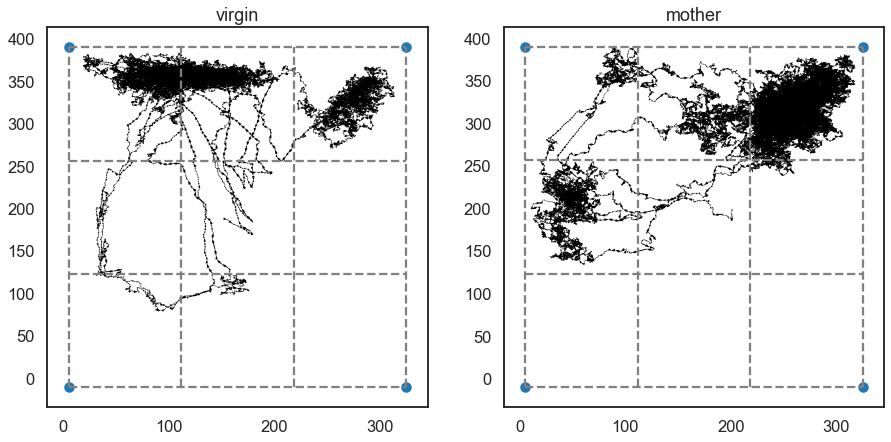

In [468]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center2, x_grids, y_grids, scale=1)

<Figure size 720x360 with 0 Axes>

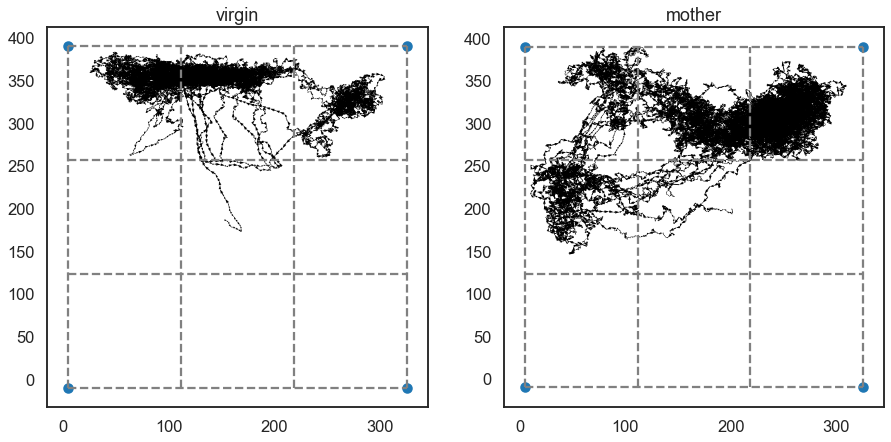

In [470]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center3, x_grids, y_grids, scale=1)

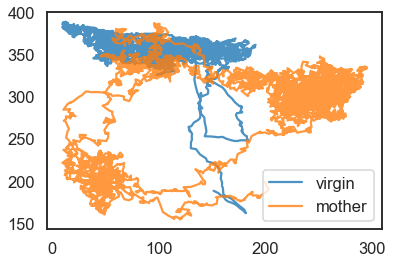

In [38]:
plot_2_mice(sample_x_center2)
plt.legend()
#plot_grid()

In [35]:
sample_z_center3, sample_x_center3 = model.sample(36000, prefix=(center_z, center_x))

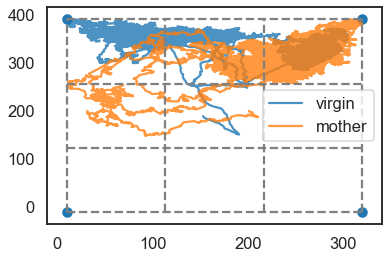

In [38]:
plot_2_mice(sample_x_center3)
plt.legend()
plot_grid()

In [39]:
sample_z_center4, sample_x_center4 = model.sample(36000, prefix=(center_z, center_x))

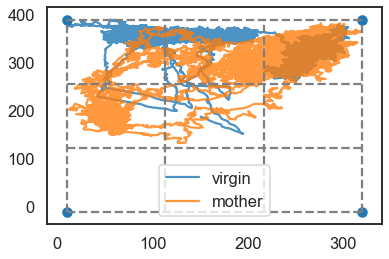

In [40]:
plot_2_mice(sample_x_center4)
plt.legend()
plot_grid()

In [44]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center3, x_grids, y_grids)

NameError: name 'sample_x_center3' is not defined

<Figure size 720x360 with 0 Axes>

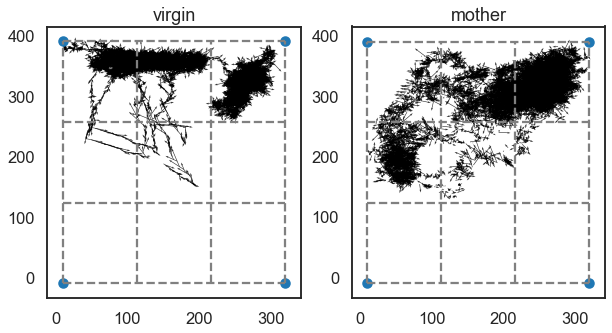

In [52]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center4)

In [27]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7438, 0.7755, 0.4080, 0.3120],
        [1.9807, 2.0146, 3.2856, 3.3133],
        [0.7220, 0.6986, 1.0906, 1.0200],
        [1.0762, 1.2390, 1.9742, 1.7643]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

# dynamics

In [32]:
plot_to_grid = {1:2, 2:5, 3: 8, 4: 1, 5: 4, 6: 7, 7:0, 8:3, 9:6}

In [33]:
def plot_weights(weights, Df):
    plt.figure(figsize=(16, 12))
    
    gap = 0.8 / (K-1)
    
    for plot_idx, grid_idx in plot_to_grid.items():
        plt.subplot(3,3,plot_idx)
        plt.title("Grid {}".format(grid_idx))
        for k in range(K):
            plt.bar(np.arange(Df) - 0.4 + k*gap, weights[grid_idx][k], width=.2, label='k={}'.format(k))
        plt.plot([0, Df], [0, 0], '-k')
        plt.ylim(0, 10)
        plt.xticks(np.arange(0,Df,1), ["lower L", "upper L", "lower R", "upper R"])
        plt.grid()
        plt.legend()

    plt.tight_layout()

In [34]:
weights_a = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_a])
weights_b = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_b])

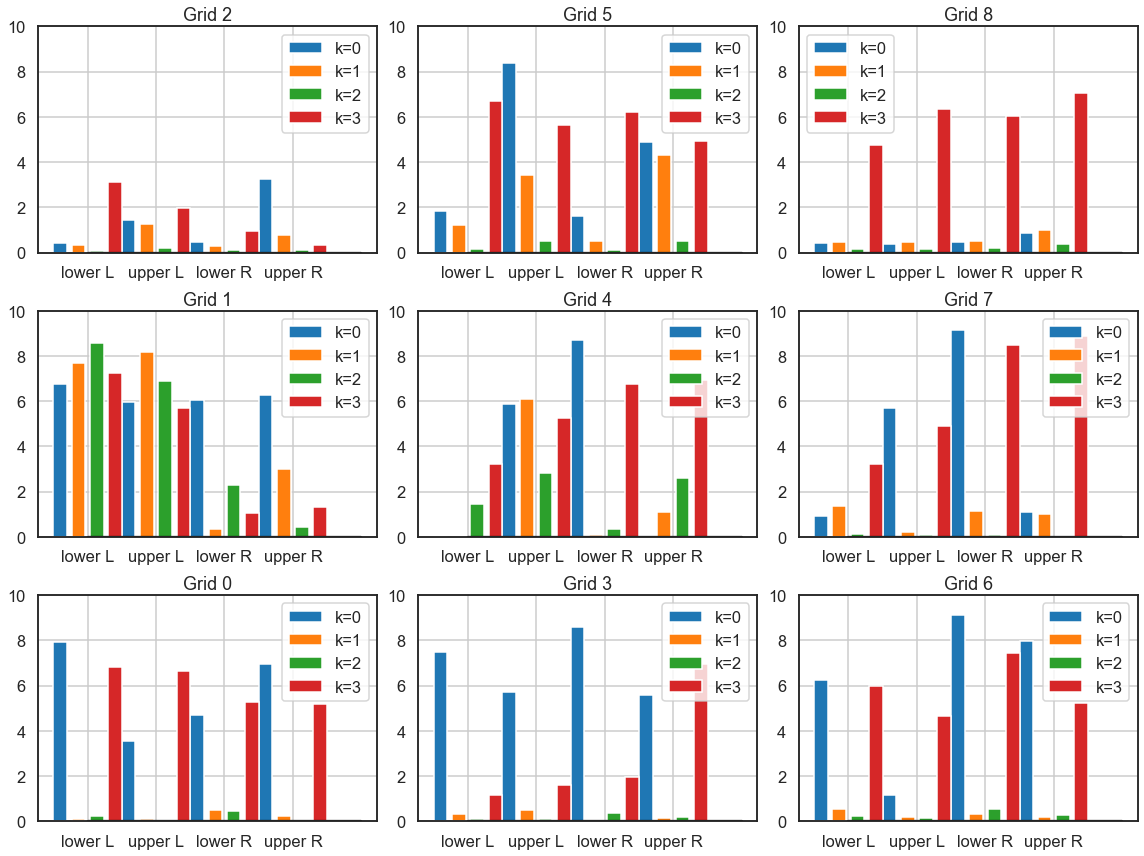

In [35]:
plot_weights(weights_a, Df=4)

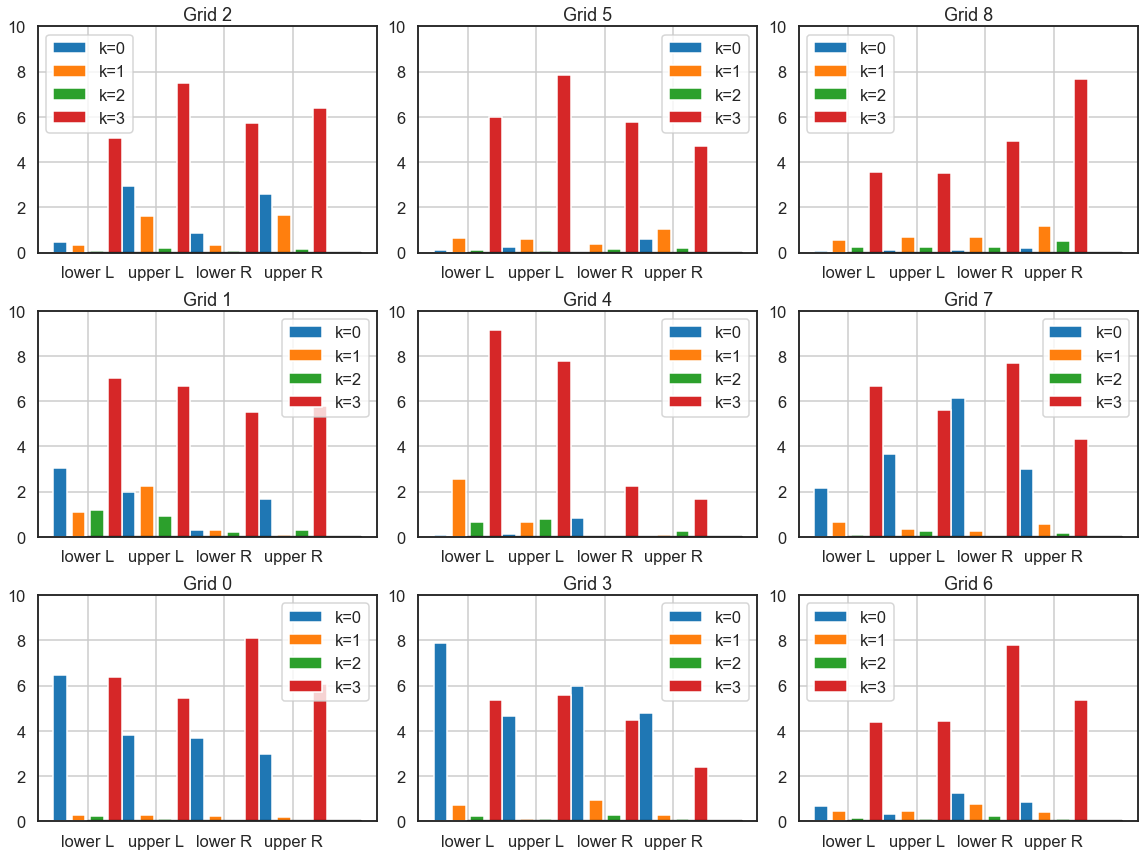

In [36]:
plot_weights(weights_b, Df=4)

In [37]:
CORNERS

tensor([[ 10., -10.],
        [ 10., 390.],
        [320., -10.],
        [320., 390.]], dtype=torch.float64)

In [38]:
grid_centers = np.array([[1/2*(x_grids[i] + x_grids[i+1]), 1/2*(y_grids[j] + y_grids[j+1])] for i in range(3) for j in range(3)])

In [39]:
out = f_corner_vec_func(torch.tensor(grid_centers, dtype=torch.float64))
corner_vecs = out.numpy()
# (G, 1, Df, d) * (G, K, Df, 1) --> (G, K, Df, d) 
weighted_corner_vecs_a = corner_vecs[:, None] * weights_a[..., None]
weighted_corner_vecs_b = corner_vecs[:, None] * weights_b[..., None]

In [40]:
out = f_corner_vec_func(torch.tensor(grid_centers[3], dtype=torch.float64))

In [41]:
# (Df, 2) * (K, Df, 1) = (K, Df, 2)
w_out = out.numpy() * weights_b[3][..., None]

In [42]:
out[0][0]

tensor([-0.9186, -0.3951], dtype=torch.float64)

In [43]:
w_out[0][0]

array([-7.2569583 , -3.12127239])

In [44]:
(CORNERS[0].numpy() - grid_centers[3] ) / w_out[0][0]

array([21.35881089, 21.35881089])

In [45]:
G = 9

In [46]:
def plot_percentage(k, percentage):
    if percentage is None:
        return
    
    texts = ["{0:.2f}%".format(percentage[g][k]*100) for g in range(G)]
    
    for c, text in zip(grid_centers, texts):
        plt.text(c[0]+20, c[1]+40, text, fontsize=12, color='k')
    

In [54]:
def plot_dynamics(weighted_corner_vecs, animal, scale=0.1, percentage=None):
    result_corner_vecs = np.sum(weighted_corner_vecs, axis=2)
    
    """
    plt.figure(figsize=(10,10))
    """
    plt.figure(figsize=(20, 5))
    
    def plot_dynamics_k(k):
        plot_grid()
        
        plot_percentage(k, percentage=percentage)
        
        for df in range(Df):
            plt.quiver(grid_centers[:,0], grid_centers[:,1], weighted_corner_vecs[:,k,df,0], weighted_corner_vecs[:,k,df,1], 
                       units='xy', scale=scale, width=2, alpha=0.5)

        plt.quiver(grid_centers[:,0], grid_centers[:,1], result_corner_vecs[:,k,0], result_corner_vecs[:,k,1],
                      units='xy', scale=scale, width=2, color='red',alpha=0.5)
        plt.title("K={}, ".format(k) + animal, fontsize=20)
    """
    plt.subplot(2,2,1)
    plot_dynamics_k(0)
    plt.subplot(2,2,2)
    plot_dynamics_k(1)
    plt.subplot(2,2,3)
    plot_dynamics_k(2)
    plt.subplot(2,2,4)
    plot_dynamics_k(3)
    """
    plt.subplot(1,4,1)
    plot_dynamics_k(0)
    plt.subplot(1,4,2)
    plot_dynamics_k(1)
    plt.subplot(1,4,3)
    plot_dynamics_k(2)
    plt.subplot(1,4,4)
    plot_dynamics_k(3)
    
    plt.tight_layout()

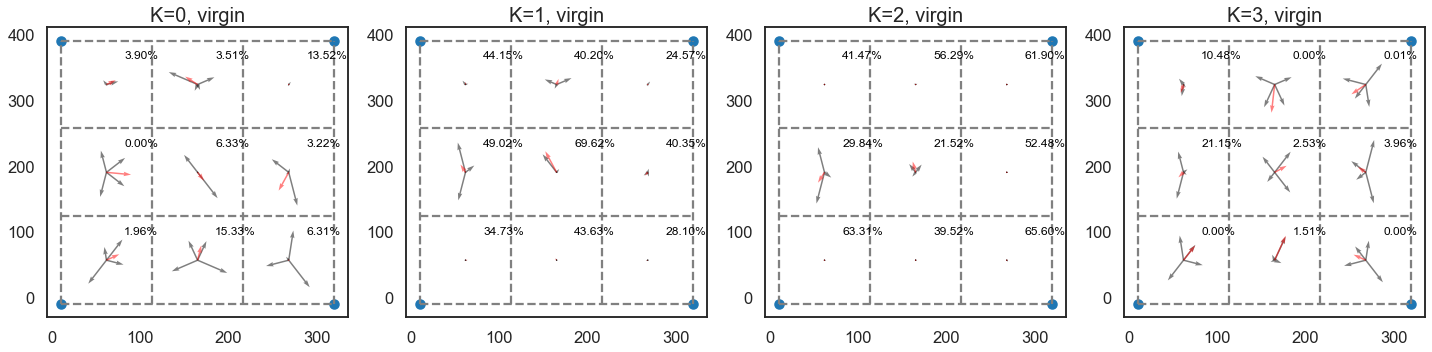

In [142]:
plot_dynamics(weighted_corner_vecs_a, "virgin", scale=0.2, percentage=grid_z_a_percentage)

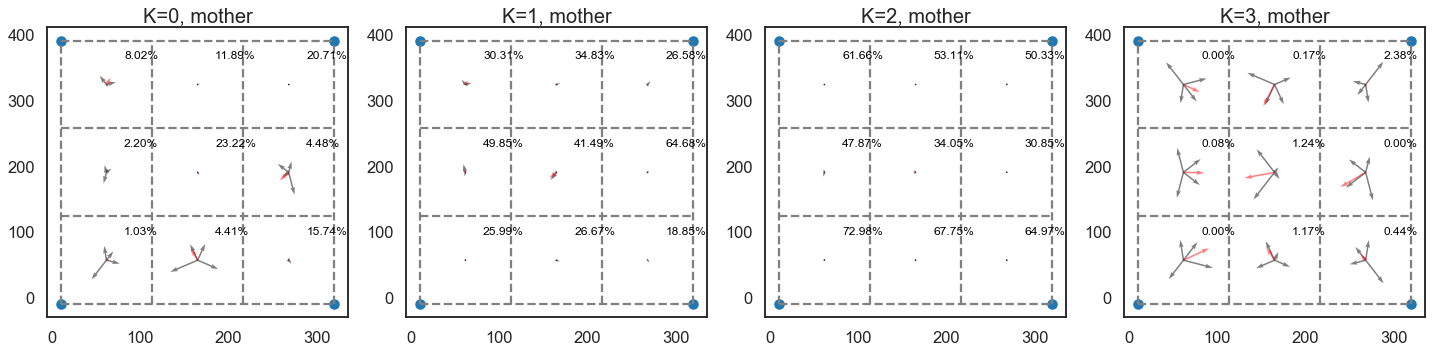

In [153]:
plot_dynamics(weighted_corner_vecs_b, "mother", scale=0.2, percentage=grid_z_b_percentage)

In [159]:
grid_centers.shape

(9, 2)

In [163]:
CORNERS

tensor([[ 10., -10.],
        [ 10., 390.],
        [320., -10.],
        [320., 390.]], dtype=torch.float64)

In [97]:
def plot_quiver(XYs, dXYs, mouse, scale=1, alpha=1):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    
    for k in range(K):
        axs[k].quiver(XYs[:, i], XYs[:, j], dXYs[:, k, i], dXYs[:, k, j],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
        axs[k].set_title('K={} '.format(k) + mouse)

    plt.tight_layout()


In [352]:
y_grids

[-10.0, 123.33333333333334, 256.6666666666667, 390.0]

In [378]:
# quiver
XX, YY = np.meshgrid(np.linspace(20, 310, 200), 
                     np.linspace(0, 380, 200))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [379]:
XY.shape

(40000, 2)

In [380]:
tran = model.observation.transformation

In [381]:
XY_grids = np.concatenate((XY, XY), axis=1)

XY_next = tran.transform(torch.tensor(XY_grids, dtype=torch.float64))
dXY = XY_next.detach().numpy() - XY_grids[:, None]


In [382]:
dXY.shape

(40000, 4, 4)

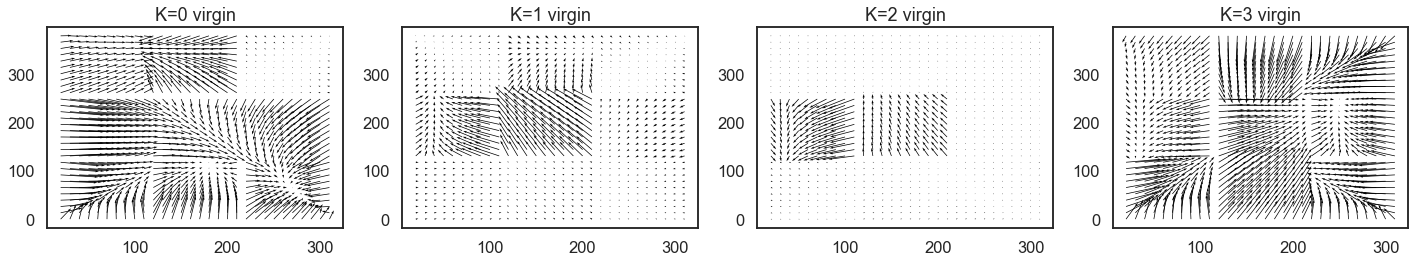

In [99]:
plot_quiver(XY_grids, dXY, 'virgin', scale=0.2)

In [59]:
[sum(z==k) for k in range(K)]

[4378, 9719, 21609, 294]

In [60]:
masks_z_a = np.array([(z[:-1] + 1) * masks_a[g].numpy() for g in range(G)])
masks_z_b = np.array([(z[:-1] + 1) * masks_b[g].numpy() for g in range(G)])

In [61]:
masks_z_a.shape

(9, 35999)

In [62]:
grid_z_a = np.array([[sum(masks_z_a[g] == k) for k in range(1,5)] for g in range(G)])
grid_z_b = np.array([[sum(masks_z_b[g] == k) for k in range(1,5)] for g in range(G)])

In [63]:
grid_z_a_percentage = grid_z_a / grid_z_a.sum(axis=1)[:,None]
grid_z_b_percentage = grid_z_b / grid_z_b.sum(axis=1)[:,None]

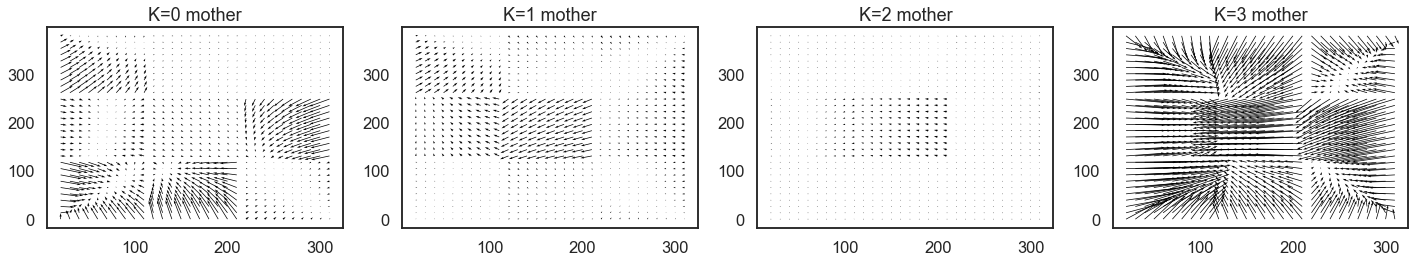

In [100]:
plot_quiver(XY_grids, dXY, 'mother', scale=0.2)

In [101]:
avg_transform_speed = np.average(np.abs(dXY), axis=0)

In [102]:
avg_sample_speed = np.average(np.abs(np.diff(sample_x, axis=0)), axis=0)

In [103]:
avg_transform_speed

array([[2.56651419, 2.35489075, 0.90033841, 1.13167177],
       [0.94599151, 1.29233028, 0.55989035, 0.54452087],
       [0.4896372 , 0.70692289, 0.19129996, 0.14327824],
       [2.4538952 , 3.47316848, 4.32419384, 2.96838109]])

In [104]:
avg_sample_speed

array([1.05355572, 0.94221308, 1.3212472 , 1.286345  ])

In [105]:
[sum(sample_z == k) for k in range(K)]

[4208, 10027, 21217, 548]